# Table of content features
## Import my libraries

In [1]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
from numpy.random import randn
# Import the stats library from numpy
from scipy import stats
import datetime as date
# These are the plotting modules adn libraries we'll use:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# Command so that plots appear in the iPython Notebook
%matplotlib inline

C:\Users\chris\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## get the data and inspect

In [2]:
main_df = pd.read_csv('https://raw.githubusercontent.com/aaronmcdaid/P2---Data-Analytics-With-Python/master/Berlin/WS%202019/5.%20Datasets/preject_datasets/main.csv')
product_df = pd.read_csv('https://raw.githubusercontent.com/aaronmcdaid/P2---Data-Analytics-With-Python/master/Berlin/WS%202019/5.%20Datasets/preject_datasets/product.csv')
attribution_df = pd.read_csv('https://raw.githubusercontent.com/aaronmcdaid/P2---Data-Analytics-With-Python/master/Berlin/WS%202019/5.%20Datasets/preject_datasets/attribution.csv')
user_article_df = pd.read_csv('https://raw.githubusercontent.com/aaronmcdaid/P2---Data-Analytics-With-Python/master/Berlin/WS%202019/5.%20Datasets/preject_datasets/user_article.csv')

In [3]:
main_df.head()
#product_df.nunique()
#attribution_df.shape
#user_article_df.shape


,user_id,birth_day,birth_month,birth_year,location,gender
0,1236805,26,2,1997,Los Angeles,M
1,2836384,13,2,1992,New York,M
2,5118289,28,2,1990,Rockville,F
3,2497066,12,2,2002,Middletown,M
4,2542664,5,2,1990,Weehawken,M


The user_atricle_df has only 25543 unique id while other dataset has 50,000.Understanding this is important.lets merge manually


In [87]:
main_attribution = main_df.merge(attribution_df)
main_attribution.head()
main_attribution_product = main_attribution.merge(product_df)
all_data = main_attribution_product.merge(user_article_df)


#Now we have all data set. lets proceed with solves the questions


-Who are our customers?   (gender,  age, where from?)                                         
-Where and what are we selling the most?  (locations, products)                                             
-Can you identify some reading patterns?  (times a day, days a week, how many times a 
-user goes back to an article,  most liked/read articles)  
-What is the correlation between article reading length - liked - times read?   
-Summarise your findings in a presentation aimed at the start up where you will tell them 
-what you found and what would be your recommendations for them.  
-Bonus - Which marketing channels are performing well?  


## Expanding the dataset for insights that we need
I would start by expanding my data to include all information that i will need. get the age of customers, convert the date 
to pd.datetime, open up the article_info column etc. 


### Add a column for age. 
define a function to calculate age.

In [88]:
def age(birth_year):
    for y in main_df.birth_year:
        y= birth_year        
        age = 2020 - y   
    return age

### Add a colums for the age group. 
define a function to split customer into teens,adults or senior citizens



In [89]:
def agegroup(n):
    if n < 19:
        return 'Teens'
    elif n >= 19 and n<45:
        return 'Adult'
    else:
        return 'Seniors'

### Unpack the article info column 
 define a function to unpack

In [90]:

def split_list(list_):
  return pd.Series(list_.replace('[', '').replace(']', '').split(','))



#### A new dataframe for the unpacked article_info 


In [91]:
all_data_art_info = all_data.article_info.apply(split_list)

#### Joining the 2 dataset 


In [92]:
all_data= pd.concat([all_data,all_data_art_info],axis =1)


#### Rename the columns


In [93]:
all_data.rename(columns={0:'art_cat',1:'art_id', 2: 'read_times'},inplace = True)


### converting
the datetime column from a string to a date and also the read_time to interger(to help us sum the readtime)


In [94]:
all_data['read_minutes'] = pd.to_numeric(all_data.read_times)
all_data['datetime'] = pd.to_datetime(all_data['datetime'],errors='coerce')


### Breaking the datetime columns into hour, day ,week ,month for better flitering


In [95]:
all_data['hour'] = all_data['datetime'].dt.hour
all_data['day'] = all_data.datetime.dt.day_name()
all_data['week'] = all_data.datetime.dt.weekofyear
all_data['month'] = all_data.datetime.dt.month_name()

### Prices and cost
####  prices of product on a column.

In [96]:
prices = {'1M':12.99,'3M':32.99,'6M':53.99,'12M':83.99}
all_data['prices'] = all_data['product'].map(prices)

#### cost calculation

CAC for marketing channels
marketing_budget_split = 
{'Criteo':185000,'TV':30000,'Facebook':550000,'Adwords':40000,'Instagram':700000,
 'Partner':'25% Share of first subscription price with minimum of 5 euros'}
 
 
the total cost for partner program = sum(0.25 of subscrition of user gotten via the  partner partner program.)


In [97]:
costmap = {'1M':3.2475,'3M':8.2475,'6M':13.4975,'12M':20.9975} #> this is the 0.25 of the subscription

Now _ what is total for partner?

In [98]:
partnerprogram = main_attribution_product[(main_attribution_product.attribution == 'Partner')]
partnerprogram['cost'] = partnerprogram['product'].map(costmap)
partnerprogram['cost'].sum()   

#>>>>>  the total cost of the partner program is 76051.395


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


76051.395

Now we have the total cost per channel is 
{'Criteo':185000,'TV':30000,'Facebook':550000,'Adwords':40000,'Instagram':700000,'Partner':76051.395}.
Let get users per channel


In [99]:
main_attribution_product.groupby(['attribution'])[['user_id']].count()

,user_id
attribution,
Adwords,5997
Criteo,4672
Facebook,14400
Friends Referral Program,2472
Instagram,15938
Partner,5942
TV,579


I creat a map dictictionary for the cost_attr by dividing the total cost of each channel by number of user of each channel

In [100]:
cost_attr = {'Criteo':185000/4672,'TV':30000/579,'Facebook':550000/14400,'Adwords':40000/5997,'Instagram':700000/15938,'Partner':76051.395/5942}

In [101]:
all_data['cost_attr'] = all_data['attribution'].map(cost_attr)

We have a created all we need in the all_data dataframe. but on inspection this frame. I notice that the frame has 
25542 users while the other frames has 50000.
Using the main_attribution_product dataframe(50k sample) gives us more sample to explore user_based_questions. 
questions 1 & 2 for instance, and also CAC or revenue_per_user based questions.So i apply all these changes
to the main_attribution_product only. see below>>>>>>>

In [102]:
main_attribution_product['age'] = main_attribution_product.birth_year.apply(age).values
main_attribution_product['agegroup'] = main_attribution_product.age.apply(agegroup).values
main_attribution_product['prices'] = main_attribution_product['product'].map(prices)
main_attribution_product['total_user_purchase'] = (main_attribution_product.prices*main_attribution_product.intervals)
main_attribution_product['cost_attr'] = main_attribution_product['attribution'].map(cost_attr)
main_attribution_product.head()

,user_id,birth_day,birth_month,birth_year,location,gender,attribution,product,intervals,purchase_date,voucher,age,agegroup,prices,total_user_purchase,cost_attr
0,1236805,26,2,1997,Los Angeles,M,Instagram,12M,1,11/7/2018 13:22,50.0,23,Adult,83.99,83.99,43.920191
1,2836384,13,2,1992,New York,M,Partner,6M,1,5/12/2018 11:29,NaN,28,Adult,53.99,53.99,12.798956
2,5118289,28,2,1990,Rockville,F,Partner,3M,3,5/31/2018 12:50,NaN,30,Adult,32.99,98.97,12.798956
3,2497066,12,2,2002,Middletown,M,Facebook,3M,5,11/16/2018 15:58,NaN,18,Teens,32.99,164.95,38.194444
4,2542664,5,2,1990,Weehawken,M,Facebook,3M,7,12/6/2018 12:26,50.0,30,Adult,32.99,230.93,38.194444


In [103]:
all_data.head()

,user_id,birth_day,birth_month,birth_year,location,gender,attribution,product,intervals,purchase_date,...,art_cat,art_id,read_times,read_minutes,hour,day,week,month,prices,cost_attr
0,2836384,13,2,1992,New York,M,Partner,6M,1,5/12/2018 11:29,...,1,11867,21,21,0.0,Wednesday,47.0,November,53.99,12.798956
1,2836384,13,2,1992,New York,M,Partner,6M,1,5/12/2018 11:29,...,2,28223,16,16,8.0,Friday,36.0,September,53.99,12.798956
2,2836384,13,2,1992,New York,M,Partner,6M,1,5/12/2018 11:29,...,6,61095,12,12,6.0,Monday,46.0,November,53.99,12.798956
3,2836384,13,2,1992,New York,M,Partner,6M,1,5/12/2018 11:29,...,7,71024,11,11,21.0,Thursday,44.0,November,53.99,12.798956
4,2836384,13,2,1992,New York,M,Partner,6M,1,5/12/2018 11:29,...,2,29103,12,12,18.0,Saturday,44.0,November,53.99,12.798956


### saving my manipulated main_attribution_product file

In [104]:
#main_attribution_product.to_csv('/Users/chris/Desktop/chris_files.csv/main_attribution_product.csv',index=False)
#all_data.to_csv('/Users/chris/Desktop/chris_files.csv/all_data.csv',index=False)

# who are our customers? 


##  explore users by  gender ,agegroup ,age etc 

### Understanding the Customers' age spread

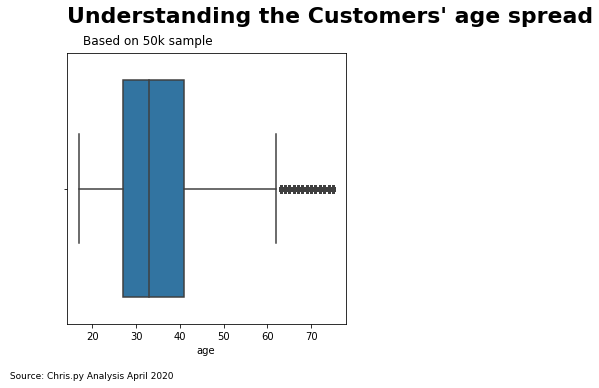

In [105]:

plt.figure(figsize=(5,5))
sns.boxplot(main_attribution_product.age)
plt.title("Understanding the Customers' age spread", 
          loc = 'left',
          pad= 30,  
          fontsize=22, 
          fontweight="bold" )
plt.suptitle('Based on 50k sample',
             x = 0.35,
             y = 0.93)
plt.text(s=' Source: Chris.py Analysis April 2020',
         x = 0.5, 
         y = 0.7, fontsize = 9)
plt.show()
#There are some outlyiers, lets see the median

### mean and median

In [106]:
print(main_attribution_product.age.median())
print(main_attribution_product.age.mean())

33.0
35.63696


### Understanding the Customers' age spread histogram

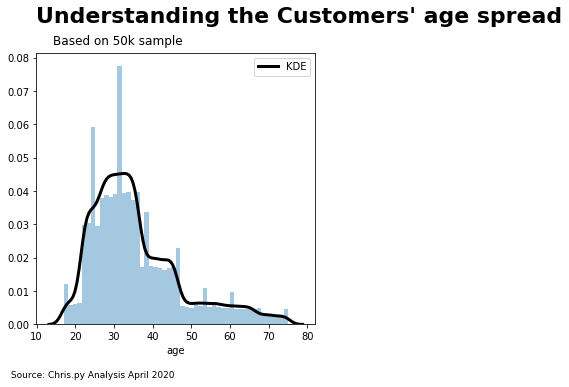

In [107]:
plt.figure(figsize=(5,5))
sns.distplot(main_attribution_product.age,kde_kws={"color": "k", "lw": 3, "label": "KDE"})
plt.title("Understanding the Customers' age spread", 
          loc = 'left',
          pad= 30,  
          fontsize=22, 
          fontweight="bold" )
plt.suptitle('Based on 50k sample',
             x = 0.35,
             y = 0.93)
plt.text(s=' Source: Chris.py Analysis April 2020',
         x = 2.5, 
         y = -0.016, fontsize = 9)
plt.show()


### Understanding the Customers' agegroup spread

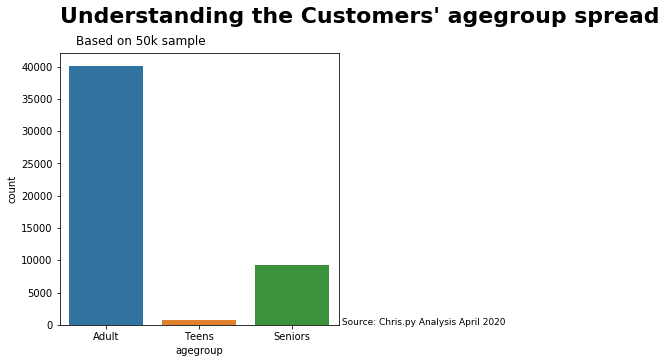

In [108]:
plt.figure(figsize=(5,5))
sns.countplot(main_attribution_product['agegroup'])
plt.title("Understanding the Customers' agegroup spread", 
          loc = 'left',
          pad= 30,  
          fontsize=22, 
          fontweight="bold" )
plt.suptitle('Based on 50k sample',
             x = 0.35,
             y = 0.93)
plt.text(s=' Source: Chris.py Analysis April 2020',
         x = 2.5, 
         y = 10.5, fontsize = 9)
plt.show()

### Understanding the Customers' agegroup/gender

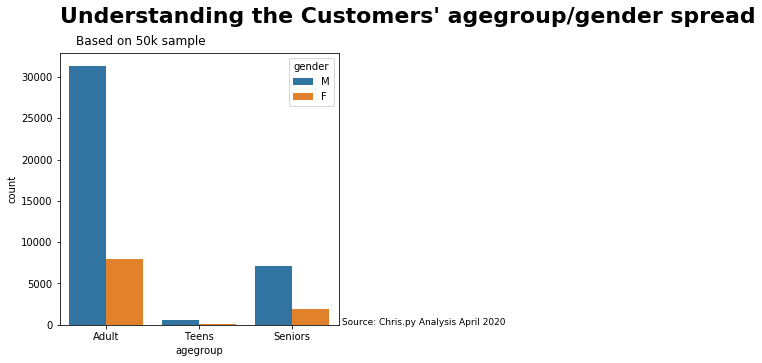

In [109]:
plt.figure(figsize=(5,5))
sns.countplot(main_attribution_product['agegroup'], hue = main_attribution_product.gender)
plt.title("Understanding the Customers' agegroup/gender spread", 
          loc = 'left',
          pad= 30,  
          fontsize=22, 
          fontweight="bold" )
plt.suptitle('Based on 50k sample',
             x = 0.35,
             y = 0.93)
plt.text(s=' Source: Chris.py Analysis April 2020',
         x = 2.5, 
         y = 10.5, fontsize = 9)
plt.show()

### Understanding the Customers' gender spread

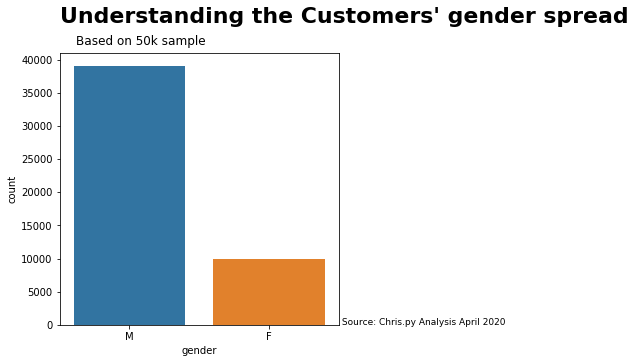

In [110]:
plt.figure(figsize=(5,5))
sns.countplot(main_attribution_product.gender)
#sns.countplot(main_attribution_product['agegroup'], hue = main_attribution_product.gender)
plt.title("Understanding the Customers' gender spread", 
          loc = 'left',
          pad= 30,  
          fontsize=22, 
          fontweight="bold" )
plt.suptitle('Based on 50k sample',
             x = 0.35,
             y = 0.93)
plt.text(s=' Source: Chris.py Analysis April 2020',
         x = 1.5, 
         y = 10.5, fontsize = 9)
plt.show()

## Explore users by location

### Top 10 location by users

In [111]:
user_location= main_attribution_product.groupby('location')[['user_id']].count()
top_10_loc= user_location['user_id'].sort_values(ascending=False).head(10)
top_10_loc

location
Philadelphia         4247
New York             4158
Charleston           3420
Los Angeles          2732
East Granby          2652
Columbus             1935
Weirton              1558
Clifton Park         1528
White Plains         1404
Lawrence Township    1364
Name: user_id, dtype: int64

### Show Top 10 location by users

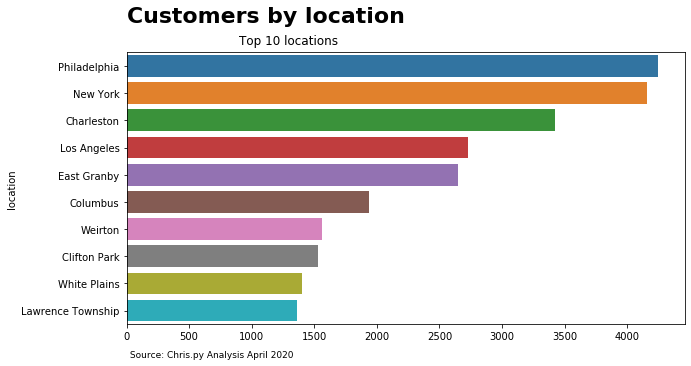

In [112]:


plt.figure(figsize=(10,5))
sns.barplot(top_10_loc.values,top_10_loc.index )
plt.title('Customers by location', 
          loc = 'left',
          pad= 30,  
          fontsize=22, 
          fontweight="bold" )
plt.suptitle('Top 10 locations',
             x = 0.35,
             y = 0.93)
plt.text(s=' Source: Chris.py Analysis April 2020',
         x = 2.5, 
         y = 10.7, fontsize = 9)
plt.show()

### Distribution by gender and agegroup per location


In [113]:
user_location_detailed= main_attribution_product.groupby(['location','gender','agegroup'])[['user_id']].count()
user_location_detailed

user_id
location gender agegroup         
Abington F      Adult         150
                Seniors        29
         M      Adult         516
                Seniors       120
                Teens           7
...                           ...
Yucaipa  F      Seniors        31
                Teens           4
         M      Adult         524
                Seniors       108
                Teens           2

[219 rows x 1 columns]

### Top 10 location detailed by gender and agegroup

In [114]:
top_10_loc_detailed = user_location_detailed['user_id'].sort_values(ascending=False).head(10)
top_10_loc_detailed

location           gender  agegroup
Philadelphia       M       Adult       2655
New York           M       Adult       2613
Charleston         M       Adult       2169
Los Angeles        M       Adult       1727
East Granby        M       Adult       1659
Columbus           M       Adult       1231
Weirton            M       Adult        986
Clifton Park       M       Adult        958
White Plains       M       Adult        856
Lawrence Township  M       Adult        839
Name: user_id, dtype: int64

####  Show Top 10 location detailed by gender and agegroup

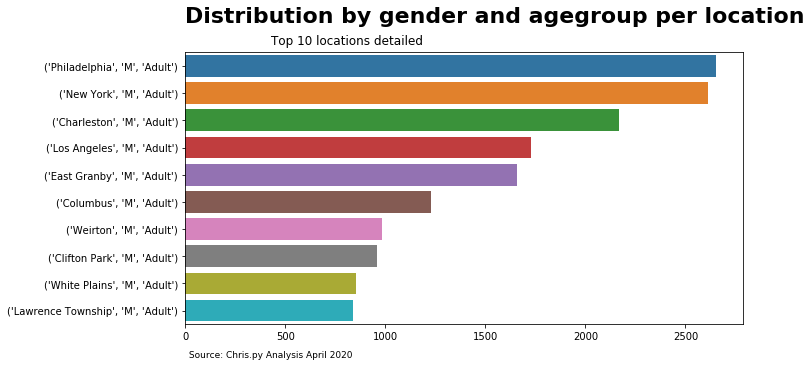

In [115]:
plt.figure(figsize=(10,5))
sns.barplot(top_10_loc_detailed.values,top_10_loc_detailed.index )
plt.title('Distribution by gender and agegroup per location', 
          loc = 'left',
          pad= 30,  
          fontsize=22, 
          fontweight="bold" )
plt.suptitle('Top 10 locations detailed',
             x = 0.35,
             y = 0.93)
plt.text(s=' Source: Chris.py Analysis April 2020',
         x = 2.5, 
         y = 10.7, fontsize = 9)
plt.show()

# Where and what are we selling the most? (locations, products,revenue,profit)

## show the product sold most

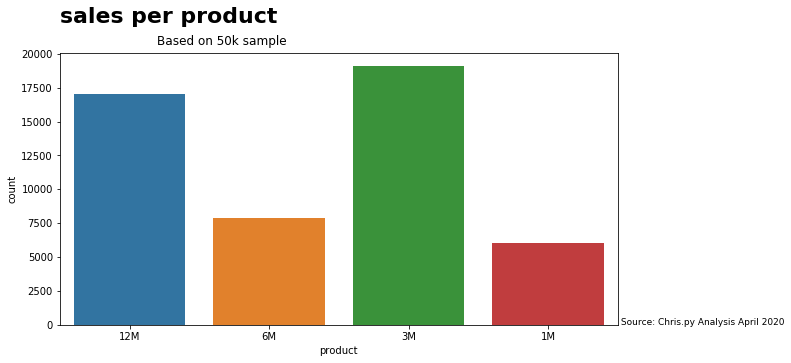

In [116]:
main_attribution_product.groupby('product').count()
plt.figure(figsize=(10,5))
sns.countplot(main_attribution_product['product'])
plt.title('sales per product', 
          loc = 'left',
          pad= 30,  
          fontsize=22, 
          fontweight="bold" )
plt.suptitle('Based on 50k sample',
             x = 0.35,
             y = 0.93)
plt.text(s=' Source: Chris.py Analysis April 2020',
         x = 3.5, 
         y = 10.7, fontsize = 9)
plt.show()


## Show Revenue generated per product

<Figure size 720x360 with 0 Axes>

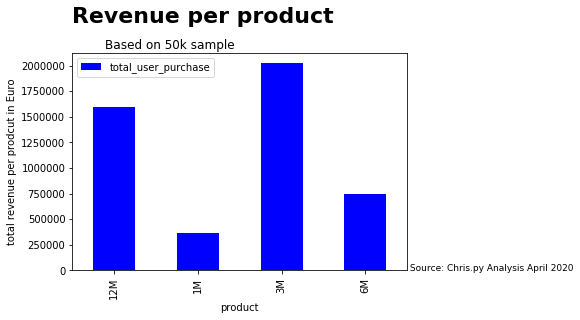

In [117]:
Revenue_per_product = main_attribution_product.groupby('product')[['total_user_purchase']].sum()
plt.figure(figsize=(10,5))
Revenue_per_product.plot(kind='bar',color = 'blue')
plt.title('Revenue per product', 
          loc = 'left',
          pad= 30,  
          fontsize=22, 
          fontweight="bold" )
plt.ylabel('total revenue per prodcut in Euro')
plt.suptitle('Based on 50k sample',
             x = 0.35,
             y = 0.93)
plt.text(s=' Source: Chris.py Analysis April 2020',
         x = 3.5, 
         y = 10.7, fontsize = 9)
plt.show()


## Top revenue locations

In [118]:
top_10_Revenue_per_location = main_attribution_product.groupby('location')[['total_user_purchase']].sum().sort_values('total_user_purchase',ascending=False).head(10)
top_10_Revenue_per_location


,total_user_purchase
location,
Philadelphia,399758.65
New York,397601.53
Charleston,321014.54
Los Angeles,257240.68
East Granby,252109.03
Columbus,183418.47
Weirton,146713.28
Clifton Park,141460.17
White Plains,131877.27


## Bottom revenue locations

In [119]:
bottom_10_Revenue_per_location = main_attribution_product.groupby('location')[['total_user_purchase']].sum().sort_values('total_user_purchase',ascending=True).head(10)
bottom_10_Revenue_per_location

,total_user_purchase
location,
Seattle,67533.81
Windsor Mill,68905.85
Peoria Heights,73811.89
Weehawken,73830.89
Yucaipa,75843.35
Clearwater,77351.47
Colorado Springs,79119.27
Voorhees,79141.10
Abington,80129.60


## Show top 10

<Figure size 7200x360 with 0 Axes>

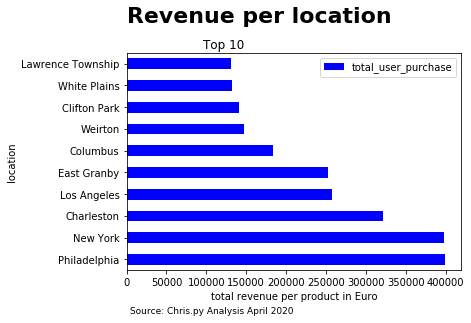

In [120]:

plt.figure(figsize=(100,5))
top_10_Revenue_per_location.plot(kind='barh',color = 'blue')
plt.title('Revenue per location', 
          loc = 'left',
          pad= 30,  
          fontsize=22, 
          fontweight="bold" )
plt.xlabel('total revenue per product in Euro')
plt.ylabel('location')
plt.suptitle('Top 10',
             x = 0.35,
             y = 0.93)
plt.text(s=' Source: Chris.py Analysis April 2020',
         x = 8.5, 
         y = -2.5, fontsize = 9)
plt.show()


## Show  bottom 10

<Figure size 7200x360 with 0 Axes>

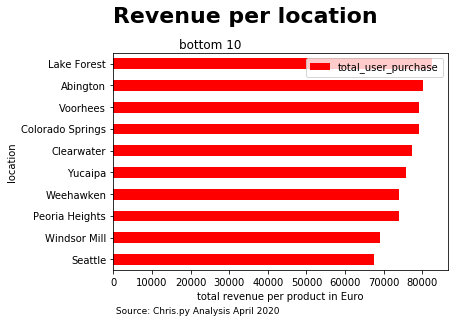

In [121]:

plt.figure(figsize=(100,5))
bottom_10_Revenue_per_location.plot(kind='barh',color = 'r')
plt.title('Revenue per location', 
          loc = 'left',
          pad= 30,  
          fontsize=22, 
          fontweight="bold" )
plt.xlabel('total revenue per product in Euro')
plt.ylabel('location')
plt.suptitle('bottom 10',
             x = 0.35,
             y = 0.93)
plt.text(s=' Source: Chris.py Analysis April 2020',
         x = 8.5, 
         y = -2.5, fontsize = 9)
plt.show()


## PROFIT of the company

In [122]:
companyprofit =(main_attribution_product.total_user_purchase.sum() - main_attribution_product.cost_attr.sum())
companyprofit

3152323.0150000006

## PROFIT of the company by location

In [123]:

main_attribution_product['profit'] = (main_attribution_product.total_user_purchase - main_attribution_product.cost_attr)
main_attribution_product.groupby('location')[['profit']].sum().sort_values('profit',ascending=False).head(10)

,profit
location,
Philadelphia,246767.570476
New York,245686.475994
Charleston,198610.807895
Los Angeles,158033.532261
East Granby,154320.771488
Columbus,114203.264197
Weirton,89315.332984
Clifton Park,86591.857052
White Plains,82463.566874


# Can you identify some reading patterns? (times a day, days a week, how many times a -user goes back to an article, most liked/read articles)

To solve this question , i used the all_data dataframe since it contains the info on articles and others columns needed.
now i start filtering to see the pattern
guiding questions: which day of the week are users reading most?
which hour of the day are users reading most?
which user read the most on the site or most active reader?
show reading patern per day of week?
how many times users goes back to an article?
the reading pattern per location?

## Identify pattern by hour

In [124]:
all_data.groupby('hour')[['read_times']].count().sort_values('read_times',ascending=False) #users read more between 7 - 9am


,read_times
hour,
8.0,127917
7.0,110201
9.0,95797
18.0,87755
20.0,63148
23.0,60156
17.0,54932
22.0,49615
19.0,47467


## Identify pattern by day

In [125]:
all_data.groupby('day')[['read_times']].count().sort_values('read_times',ascending=False) #user read most on thurdays and sunday

,read_times
day,
Thursday,151309
Sunday,150422
Wednesday,141362
Tuesday,132158
Friday,129499
Saturday,126614
Monday,124542


## 5 Most active readers

In [126]:
all_data.groupby(['user_id'])[['read_minutes']].sum().sort_values('read_minutes',ascending=False).head(5)

,read_minutes
user_id,
3125436,997
9641172,954
3535149,949
5562041,945
7862284,939


## Showing these trends

### Show daily trends

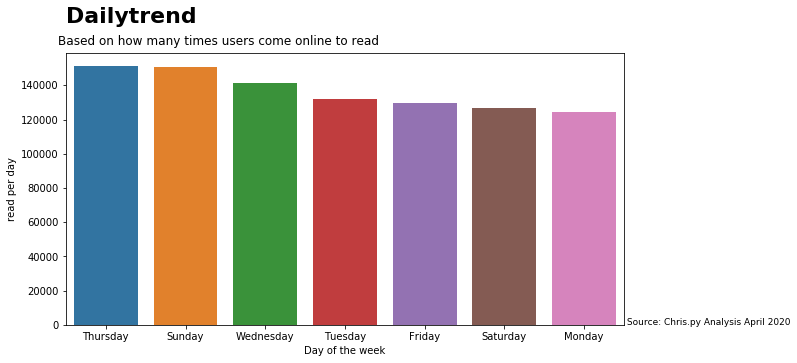

In [127]:

dailytrend = all_data.groupby('day')[['read_times']].count().sort_values('read_times',ascending=False) #user read most on thurdays
dailytrend.reset_index(inplace= True)

plt.figure(figsize=(10,5))
sns.barplot(x='day', y = 'read_times', data = dailytrend)
plt.title('Dailytrend', 
          loc = 'left',
          pad= 30,  
          fontsize=22, 
          fontweight="bold" )
plt.xlabel('Day of the week')
plt.ylabel('read per day')
plt.suptitle('Based on how many times users come online to read ',
             x = 0.34,
             y = 0.93)
plt.text(s=' Source: Chris.py Analysis April 2020',
         x = 6.5, 
         y = 10.5, fontsize = 9)
plt.show()



### Show hour trend

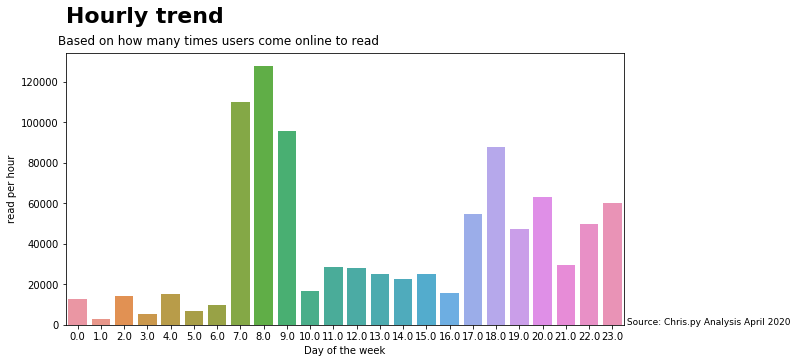

In [128]:
hourtrend = all_data.groupby('hour')[['read_times']].count().sort_values('read_times',ascending=False).reset_index()

plt.figure(figsize=(10,5))
sns.barplot(x='hour', y = 'read_times', data = hourtrend)
plt.title('Hourly trend', 
          loc = 'left',
          pad= 30,  
          fontsize=22, 
          fontweight="bold" )
plt.xlabel('Day of the week')
plt.ylabel('read per hour')
plt.suptitle('Based on how many times users come online to read ',
             x = 0.34,
             y = 0.93)
plt.text(s=' Source: Chris.py Analysis April 2020',
         x = 23.5, 
         y = 25.5, fontsize = 9)
plt.show()



 ## Average time an article is read

In [129]:
article_repeat = all_data.groupby(['art_id'])[['read_times']].count().reset_index()
article_repeat.read_times.mean() #the averarge repeat time per article is 1203.02 

1203.020757020757

 ## Average time users read

In [130]:
all_data.groupby(['user_id'])[['read_times']].count().mean()
#User read an average of 38.5 times

read_times    38.573151
dtype: float64

 ## Average time users repeat an article

In [131]:
all_data.groupby(['user_id','art_id',])[['read_times']].count().mean()



read_times    1.023889
dtype: float64

## Most liked/read articles)

To get the most liked

In [132]:
liked_article = all_data[(all_data.liked == 1)] 
liked_article.head(3)

,user_id,birth_day,birth_month,birth_year,location,gender,attribution,product,intervals,purchase_date,...,art_cat,art_id,read_times,read_minutes,hour,day,week,month,prices,cost_attr
0,2836384,13,2,1992,New York,M,Partner,6M,1,5/12/2018 11:29,...,1,11867,21,21,0.0,Wednesday,47.0,November,53.99,12.798956
2,2836384,13,2,1992,New York,M,Partner,6M,1,5/12/2018 11:29,...,6,61095,12,12,6.0,Monday,46.0,November,53.99,12.798956
3,2836384,13,2,1992,New York,M,Partner,6M,1,5/12/2018 11:29,...,7,71024,11,11,21.0,Thursday,44.0,November,53.99,12.798956


### The most liked article

In [133]:
liked_article.groupby('art_id')[['liked']].count().sort_values('liked',ascending=False)
#60605 - 801 likes

,liked
art_id,
60605,801
70174,797
51798,797
70894,789
11757,787
...,...
52388,659
52518,658
11927,656


### The most read articles


In [134]:
all_data.groupby('art_id')[['read_times']].count().sort_values('read_times',ascending=False)
#article 11757 was read 1299 times


,read_times
art_id,
11757,1299
36204,1297
52238,1293
70564,1287
11637,1285
...,...
29023,1114
12357,1112
29043,1111


### Showing top 5 most liked article

<Figure size 720x360 with 0 Axes>

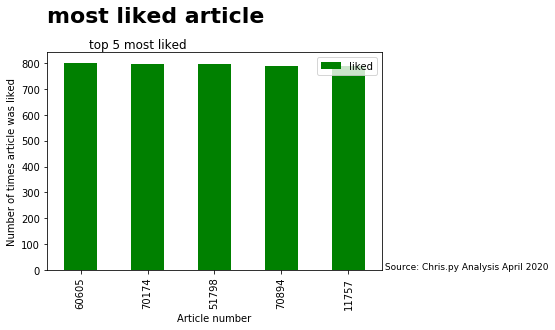

In [135]:
liked_article_chart = liked_article.groupby('art_id')[['liked']].count().sort_values('liked',ascending=False).head(5)
plt.figure(figsize=(10,5))
liked_article_chart.plot(kind='bar',color = 'g')
plt.title('most liked article', 
          loc = 'left',
          pad= 30,  
          fontsize=22, 
          fontweight="bold" )
plt.xlabel('Article number')
plt.ylabel('Number of times article was liked')
plt.suptitle('top 5 most liked ',
             x = 0.34,
             y = 0.93)
plt.text(s=' Source: Chris.py Analysis April 2020',
         x = 4.5, 
         y = 2.5, fontsize = 9)
plt.show()


### Showing top 5 most read article

<Figure size 720x360 with 0 Axes>

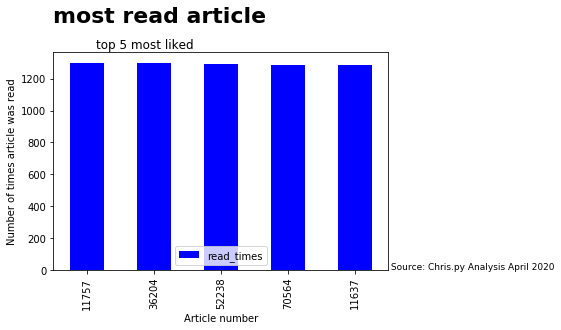

In [136]:
most_read_chart = all_data.groupby('art_id')[['read_times']].count().sort_values('read_times',ascending=False).head(5)
plt.figure(figsize=(10,5))
most_read_chart.plot(kind='bar',color = 'b')
plt.title('most read article', 
          loc = 'left',
          pad= 30,  
          fontsize=22, 
          fontweight="bold" )
plt.xlabel('Article number')
plt.ylabel('Number of times article was read')
plt.suptitle('top 5 most liked ',
             x = 0.34,
             y = 0.93)
plt.text(s=' Source: Chris.py Analysis April 2020',
         x = 4.5, 
         y = 2.5, fontsize = 9)
plt.show()


# What is the correlation between article reading length - liked - times read?

## Correlate the read lenght and read times

In [137]:
correlate = liked_article.groupby(['art_id']).agg({'read_minutes': 'sum','read_times': 'count'})
correlate.corr()


,read_minutes,read_times
read_minutes,1.000000,0.046857
read_times,0.046857,1.000000


## show the correlation

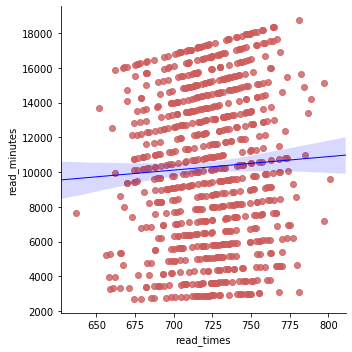

In [138]:
sns.lmplot('read_times','read_minutes',correlate,
          scatter_kws={'marker': 'o','color': 'indianred'},
          line_kws = {'linewidth': 1,'color': 'blue'})


#There is an insignificant relation .

# Bonus - Which marketing channels are performing well?

## Channel cost performance

In [139]:
efficient_map= {'Criteo':185000/4672,'TV':30000/579,'Facebook':550000/14400,'Adwords':40000/5997,'Instagram':700000/15938,'Partner':76051.395/5942}
channel_performance = pd.DataFrame(efficient_map,index=['>>>'])
channel_performance
#Adwords is the most efficient channel 

,Criteo,TV,Facebook,Adwords,Instagram,Partner
>>>,39.597603,51.813472,38.194444,6.670002,43.920191,12.798956


## check quality of customer from different channels

In [140]:
main_attribution_product.groupby('attribution')[['total_user_purchase']].mean().sort_values('total_user_purchase',ascending=False).head(10)
#users per channel spending is fairly same but instagram users purchased more. 
#However the Friends Referral Program is worth of continuation

,total_user_purchase
attribution,
Instagram,95.114417
Friends Referral Program,94.737981
Facebook,94.591593
Adwords,94.359873
Partner,94.352642
Criteo,94.325452
TV,93.128722


In [141]:
main_attribution_product.groupby('attribution')[['user_id']].count()

,user_id
attribution,
Adwords,5997
Criteo,4672
Facebook,14400
Friends Referral Program,2472
Instagram,15938
Partner,5942
TV,579


# Recommendations

1. The company needs to develop articles that will attract ladies to the site. Prehaps direct the channels to target females 
2. Teenagers also needs to be attracted to the site(teenagers share of the compnay is low)
3. 3 month product is selling best
4. The company is in profit and all location are profitable , i recommend the discontinuation of vouchers
5. Identify similar articles to the most read articles and suggest it to users . This will help with customer satifaction.
6. Channel Adwords is more cost effecient . Its cost the channel 6.6 euro to get a new user and the quality of their users are similar to channels like instagram and facebook with high cost per users. Highly recomments that their  budget is increased